In [1]:
import sys
sys.path.append('../')

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from drone_mdl import *
import time

In [2]:
from drone_opt import *

Example model and parameters:

In [3]:
params={'start': [0.0,0.0, 10, 10], 'target': [0, 150, 160, 160], 'safe': [0, 50, 10, 10], # areas
        'flightplan':{ 1:[0,0,50], 2:[100, 200, 50], 3:[100, 100, 85], 4:[-25, 150, 20],5:[75, 300, 20],6:[0, 300, 20], 7:[0,0,50], 8:[0,0,0] },
        'bat':'series-split',                           #'monolithic', 'series-split', 'paralel-split', 'split-both'
        'linearch':'quad',                              #quad, hex, oct
        'respolicy':{'bat':'emland','line':'emland'}}   #continue, to_home, to_nearest, emland
mdl = Drone(params=params)

### Design model

The drone model has 4 possible battery architectures: monolithic, series-split, parallel-split, and split-both. Each of these architectures enable some reconfiguration of the battery in case of faults but also add design cost, and (more importantly), weight. 

The drone model also has 3 possible line architectures (quadrotor, hexarotor, and octorotor) which increase design resilience but also lead to both increased design cost, weight, and drag.

The cost of a model can be tabulated using `calc_des` in `drone_opt`.

In [4]:
calc_des(mdl)

50000

To get the objective in terms of the design vector $x_{des}$, use `x_to_descost`.

In [5]:
x_des = [0,0]

In [6]:
x_to_dcost(x_des)

0

### Operational model

The drone model has 1 operational variable - the flight height. This variable determines how high the drone flies and thus how detailed of an image it can caputure. Based on this height, a flightplan is determined.

The operational model models the function of the battery, motors, and trajectory of the craft over time, as shown:

invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points


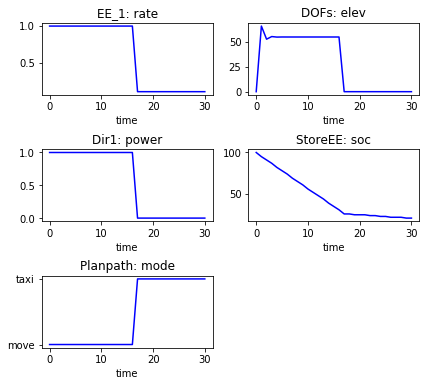

In [23]:
endresults_nom, resgraph, mdlhist =propagate.nominal(mdl)
rd.plot.mdlhistvals(mdlhist,fxnflowvals={'StoreEE':'soc', 'EE_1':'rate', 'DOFs': 'elev', 'Planpath':'mode', 'Dir1':'power'})

The flightplan generated for this model is shown below:

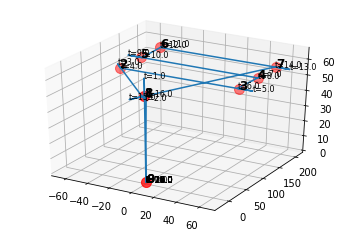

In [24]:
fp = mdl.params['flightplan']

fig1 = plt.figure()

ax2 = fig1.add_subplot(111, projection='3d')

xnom=mdlhist['flows']['DOFs']['x']
ynom=mdlhist['flows']['DOFs']['y']
znom=mdlhist['flows']['DOFs']['elev']
time = mdlhist['time']

for goal,loc in fp.items():
    ax2.text(loc[0],loc[1],loc[2], str(goal), fontweight='bold', fontsize=12)
    ax2.plot([loc[0]],[loc[1]],[loc[2]], marker='o', markersize=10, color='red', alpha=0.5)
for xx,yy,zz,tt in zip(xnom,ynom,znom,time):
    ax2.text(xx,yy,zz, 't='+str(tt), fontsize=8)
ax2.plot(xnom,ynom,znom)

We can then see how this plan covers the space of points to view:

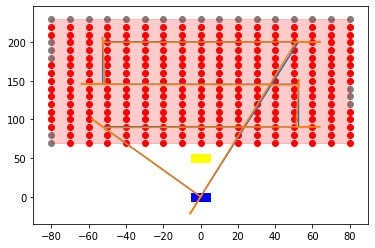

In [25]:
fig2 = plt.figure()

x_traj = [a[0] for k,a in fp.items()]
y_traj = [a[1] for k,a in fp.items()]

plt.plot(x_traj, y_traj)
plt.plot(mdlhist['flows']['DOFs']['x'], mdlhist['flows']['DOFs']['y'])

xviewed = [x for (x,y),view in endresults_nom['classification']['viewed'].items() if view!='unviewed']
yviewed = [y for (x,y),view in endresults_nom['classification']['viewed'].items() if view!='unviewed']
xunviewed = [x for (x,y),view in endresults_nom['classification']['viewed'].items() if view=='unviewed']
yunviewed = [y for (x,y),view in endresults_nom['classification']['viewed'].items() if view=='unviewed']

plt.scatter(xviewed,yviewed, color='red')
plt.scatter(xunviewed,yunviewed, color='grey')

plt.fill([x[0] for x in mdl.start_area],[x[1] for x in mdl.start_area], color='blue')
plt.fill([x[0] for x in mdl.target_area],[x[1] for x in mdl.target_area], alpha=0.2, color='red')
plt.fill([x[0] for x in mdl.safe_area],[x[1] for x in mdl.safe_area], color='yellow')

The cost of a model is tabulated using `calc_oper` in `drone_opt`, along with the value of constraints:
- battery max discharge (20%)
- existence of faults
- max height (122 m per FAA regulation)

In [7]:
calc_oper(mdl)

invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points


(-207720.86258662076, -4, False, 0)

This operational cost and constraint values can be optimized in terms of design and operational variables $x_{des}$ and $x_{oper}$ using `x_to_ocost`.

In [8]:
x_oper = [200]

In [9]:
x_to_ocost(x_des, x_oper)

invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points


(-9633.27207777756, -32, False, 657.3332480000005)

### Resilience model

The resilience model has two variables--the battery resilience policy, and the line resilience policy, which each determine how the flight plan changes based on faults detected in the battery and line, respectively.

The resilience cost of a model can be calculated using `calc_res`.

In [10]:
rescost = calc_res(mdl)

invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid po

In [11]:
rescost

30471853.407649126

This can be calculated in terms of the design, operational, and variables $x_{des}$, $x_{oper}$, and $x_{res}$ using `x_to_rcost`

In [12]:
x_res = [0,0]

In [13]:
rescost = x_to_rcost(x_des, x_oper, x_res)

invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid po

In [14]:
rescost

171566.93090361136

The model can also be queried in terms of the entire design vector using `x_to_mdl` and `x_to_cost`:

In [15]:
x=[0,0,55,1,1]

In [16]:
mdl = x_to_mdl(x)

In [18]:
cost, constraints = x_to_cost(x)

invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid points
invalid po

In [19]:
cost

10246125.220982239

In [20]:
constraints

(-1, False, 0)